In [1]:
import pandas as pd
from square.decisiontreegm import DecisionTreeGM

df = pd.read_csv("data/consolidatedhyp.csv")

xcols = list(df.columns)
xcols.remove('censored')
xcols.remove('not_censored')

In [2]:
import numpy as np
from scipy.special import betaln

def model_evidence(point):
    success, failure = point
    return betaln(success + .5, failure + .5) - betaln(.5, .5)

def point_estimator(y):
    return [sum(y[:, 0]), sum(y[:,1])]

def test_statistic(left_y, right_y):
    together = np.vstack((left_y,right_y))
    left_model = model_evidence(point_estimator(left_y))
    right_model = model_evidence(point_estimator(right_y))
        
    log_split_like = left_model + right_model
    
    return {'statistic': -log_split_like, 'aux': together}

def stopping_test(aux, depth, ncols):
    main_model = model_evidence(point_estimator(aux['aux']))
    log_bf = main_model + aux['statistic']
    
    if log_bf >= 0:
        return False
    return True


0
1
2


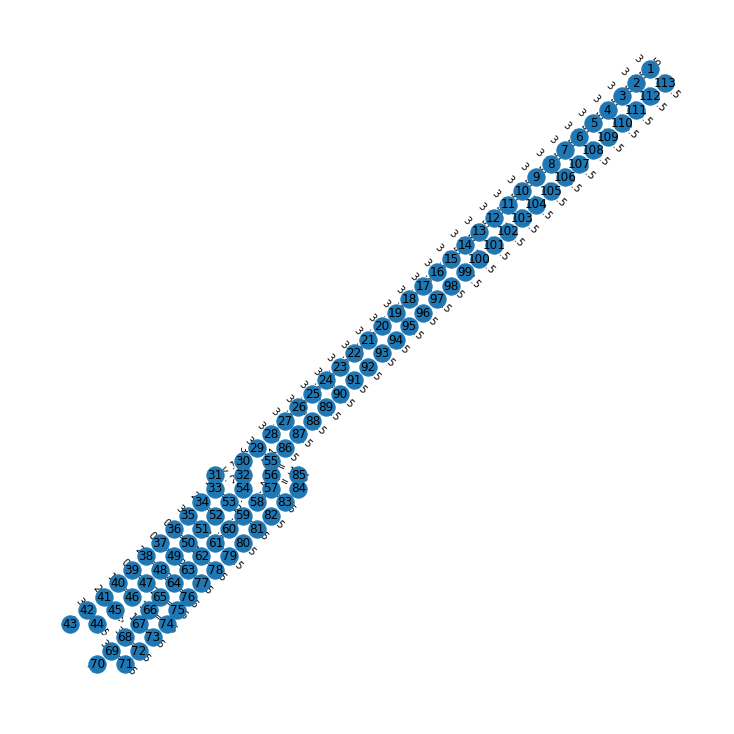

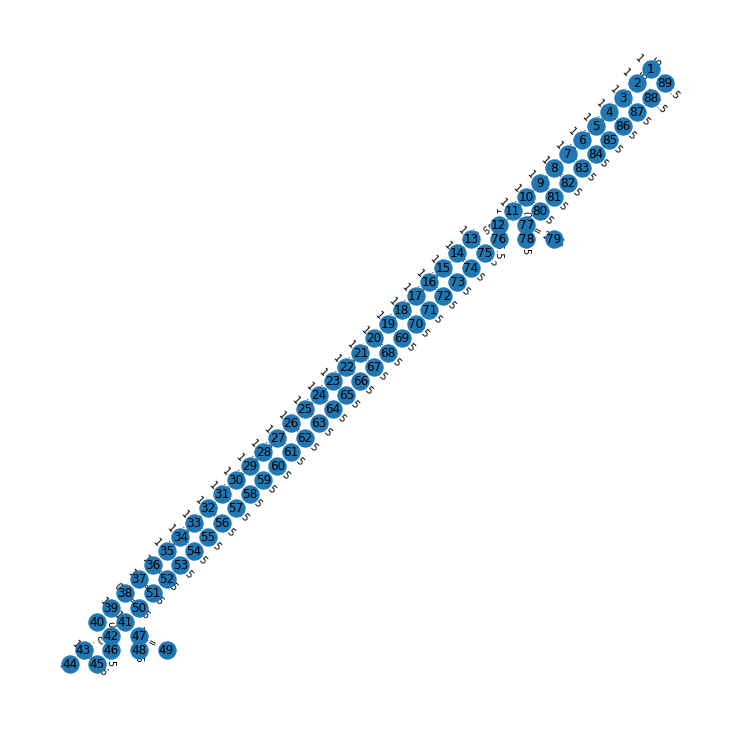

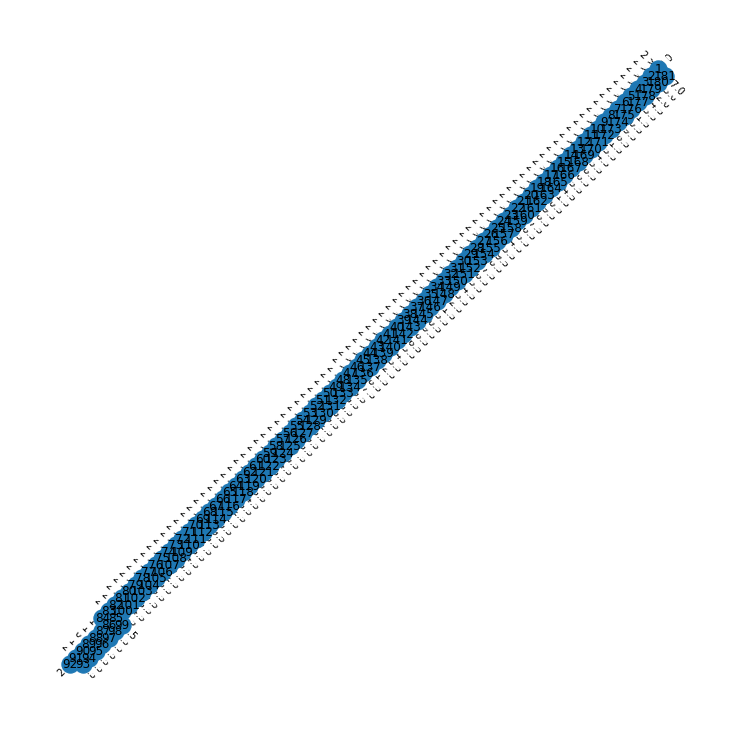

In [3]:
from hypothesises import *

for index, hyp in enumerate(HYPOTHESISES):
    X = df.groupby(hyp).agg({'censored':'sum','not_censored':'sum'}).reset_index()
    
    y = X.loc[:,['censored','not_censored']].values
    X = X.loc[:, hyp].values
    
    dtg = DecisionTreeGM(point_estimator, test_statistic, stopping_test)
    dtg.fit(X,y)
    
    
    comp = dtg.get_dataframe(dtg, hyp, integers = True)
    comp.to_csv(f"compressed{index}.csv", index = False)
    
    print(index)

In [ ]:

dfs = df.copy()
for name in xcols:
    dff = df.groupby(name).agg({'censored':'sum','not_censored':'sum'}).reset_index()

    y = dff.loc[:,['censored','not_censored']].values
    X = dff.loc[:,name].values
    
    dtg = DecisionTreeGM(point_estimator,test_statistic,stopping_test)
    
    dtg.fit(X, y)

    comp = dtg.get_dataframe(dtg, name, integers = True)
    if comp.shape[1] > 2:
        mm = comp[name].astype(int).max()
        dfs[name] = (df[name] >= mm).astype(int)
    else:
        del dfs[name]

dfs

In [ ]:
dfs = df.copy()
for name in xcols:
    un = df[name].quantile(.5)
    dfs[name] = (df[name] > un).astype(int)

dfs.to_csv("quantile.csv",index=False)

In [ ]:
from hypothesises import *
import statsmodels.api as sm
import patsy

for hyp in HYPOTHESISES:
    hyp2 = hyp
    if 'tokencount' in hyp2:
        hyp2.remove('tokencount')
    formula = "censored + not_censored ~ 1 + " + '*'.join(hyp2) + '+ tokencount'
    y, X = patsy.dmatrices(formula, dfs)
    
    results = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    print(results.summary())

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Number of bins
num_bins = int(np.sqrt(29461))

# Get the predicted values
y_pred = results.mu

# Get deviance residuals
residuals = results.resid_deviance

# Create a dataframe with your predictions and residuals
data = pd.DataFrame({'y_pred': y_pred, 'residuals': residuals})

# Create bins of predicted values

data['bin'] = pd.cut(data['y_pred'], bins=num_bins, labels = False)

# Group by the bins
binned = data.groupby('bin').agg({'y_pred': np.mean, 'residuals': np.mean})

# Create the plot
plt.scatter(binned['y_pred'], binned['residuals'])
plt.xlabel('Mean Predicted Value')
plt.ylabel('Mean Residual')
plt.title('Binned Residual Plot')
plt.show()